### Mounting Google Drive
We mount Google Drive to access our dataset stored in Drive.  
This allows us to read and save files directly from Colab. 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing Required Libraries

We import all the necessary libraries for our Rice Image Classification project:

- **os** → for file and directory operations  
- **pandas, numpy** → for data handling and numerical computations  
- **matplotlib, seaborn** → for data visualization and plotting  
- **random** → for random sampling and reproducibility  
- **cv2 (OpenCV)** → for image processing tasks  
- **tensorflow / keras** → for building and training the deep learning model  
- **PIL (Python Imaging Library)** → for additional image handling  
- **sklearn.metrics** → for evaluation metrics like confusion matrix & classification report  

**From Keras specifically:**
- **layers & models** → to build the CNN architecture  
- **Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D** → CNN layers for feature extraction & classification  
- **optimizers (Adam, Adamax)** → optimization algorithms  
- **ImageDataGenerator** → to augment training images  
- **load_img, img_to_array** → for image preprocessing


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import cv2
import tensorflow as tf
import zipfile
from PIL import Image


from sklearn.metrics import classification_report, confusion_matrix


from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.layers import Dense, Dropout, Activation,Flatten, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

### Checking Google Drive Contents

We define the path to our Google Drive folder and list all files/folders inside it.


In [4]:
drive_path = "/content/drive/MyDrive"
os.listdir(drive_path)

['Katdrive',
 'Colab Notebooks',
 'documents',
 '.ipynb_checkpoints',
 'archive.zip',
 'gen ai resume 3 (2).pdf',
 'gen ai resume 3 (1).pdf',
 'gen ai resume 3.pdf',
 'archive1.zip']

- We specify the path of our Rice Image Dataset (stored as a ZIP file in Google Drive).


In [5]:
zip_file = "/content/drive/MyDrive/archive1.zip"

### Extraction Folder

We define the destination folder where the dataset will be extracted.


In [6]:
extract_folder = '/content/dataset'

In [7]:
print(os.makedirs(extract_folder, exist_ok = True))

None


### Extracting the Dataset

We extract the contents of the ZIP file into the specified folder.


In [8]:
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
  zip_ref.extractall(extract_folder)

In [9]:
print(os.listdir(extract_folder))

['Rice_Image_Dataset']


- The dataset is balanced, with 15,000 images per class across the 5 rice varieties.

- A balanced dataset helps the model learn equally well for each rice type and reduces bias.

In [10]:
train_dir = '/content/dataset/Rice_Image_Dataset'
rice_classes = os.listdir(train_dir)
class_counts = {}
# count images in each class
print("rice class counts for training:")
for rice in rice_classes:
    rice_dir = os.path.join(train_dir, rice)
    if os.path.isdir(rice_dir):  # check if it’s a directory
        count = len(os.listdir(rice_dir))
        class_counts[rice] = count
        print(f"{rice}: {count} images")

rice class counts for training:
Ipsala: 15000 images
Jasmine: 15000 images
Karacadag: 15000 images
Basmati: 15000 images
Arborio: 15000 images


### Visualizing Sample Images from Each Rice Class

We display a few sample images from each rice variety to get an idea of the dataset.

What this does:

Iterates through each rice class folder.

Picks a sample image (index 42) from each class.

Reads the image using OpenCV, converts it from BGR → RGB for proper coloring.

Displays them in a grid with titles.

Output Example:
A grid of rice images with each subplot labeled as Arborio, Basmati, Ipsala, Jasmine, Karacadag.

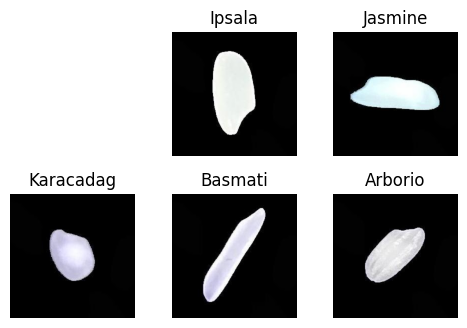

In [12]:
rice = os.listdir(train_dir)

plt.figure(figsize=(5, 5))

for i, rices in enumerate(rice, 1):
    img_list = os.listdir(os.path.join(train_dir, rices))
    if len(img_list) > 42:  # make sure index 42 exists
        img_path = os.path.join(train_dir, rices, img_list[42])
        img = cv2.imread(img_path)  # OpenCV reads in BGR
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        ax = plt.subplot(3, 3, i)
        plt.imshow(img)
        plt.title(rices)
        plt.axis('off')

plt.tight_layout()
plt.show()

### Checking a Sample Image Shape

We load one sample image from the Arborio class and print its dimensions  
to verify that images are being read properly.

Reads the image using OpenCV.

Checks if the image was loaded successfully.

If successful, prints the shape (height, width, channels).

For example: (250, 250, 3) → 250×250 pixels, 3 color channels (RGB).

If not, prints an error message.

In [13]:
image='/content/dataset/Rice_Image_Dataset/Arborio/Arborio (1).jpg'
img=cv2.imread(image)
if img is not None:
    print(img.shape)
else:
    print(f"Failed to load image from {image}")

(250, 250, 3)


### Defining Dataset Directory

We create a variable to store the path of the Rice Image Dataset.  
This makes the code cleaner and easier to maintain.


In [14]:
rice_data_dir = '/content/dataset/Rice_Image_Dataset'

### Removing Unnecessary System Folders

Sometimes, Google Colab creates hidden folders like `.ipynb_checkpoints`  
inside the dataset directory. These are not part of the dataset and can cause issues  
when loading images with `ImageDataGenerator`.

We remove such folders using `shutil.rmtree`.


In [15]:
import shutil
shutil.rmtree(rice_data_dir + '/.ipynb_checkpoints', ignore_errors=True)


### Data Preprocessing with ImageDataGenerator

We use Keras ImageDataGenerator to preprocess the rice images before training.

rescale=1./255 → Normalizes pixel values from [0, 255] to [0, 1] for faster training.

validation_split=0.2 → Splits 20% of the dataset for validation.

target_size=(250,250) → Resizes all images to 250×250 pixels.

batch_size=32 → Feeds 32 images at a time to the model.

class_mode='categorical' → Since this is a multi-class classification problem (5 classes).

color_mode='grayscale' → Converts images to grayscale (single channel).

subset='training' / 'validation' → Creates separate generators for training and validation.

In [16]:
# rescale the pixel values to [0,1]
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    rice_data_dir,
    target_size=(250,250),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    rice_data_dir,
    target_size=(250,250),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation'
)

Found 60000 images belonging to 5 classes.
Found 15000 images belonging to 5 classes.


### Checking Class Labels

We retrieve the mapping of rice classes to their corresponding numeric labels  
for both training and validation sets.

train_generator.class_indices → Returns a dictionary mapping each class name to an integer label.

validation_generator.class_indices → Same mapping for validation data.

Ensures the class order is consistent during training and prediction.


In [17]:
# accessing the class lablel for the training data
train_class_labels=train_generator.class_indices
print('train class labels',train_class_labels)

validation_class_labels=validation_generator.class_indices
print('validation class labels',validation_class_labels)

train class labels {'Arborio': 0, 'Basmati': 1, 'Ipsala': 2, 'Jasmine': 3, 'Karacadag': 4}
validation class labels {'Arborio': 0, 'Basmati': 1, 'Ipsala': 2, 'Jasmine': 3, 'Karacadag': 4}


In [18]:
num_classes = len(train_class_labels)
print("Number of classes:", num_classes)

Number of classes: 5


### Building the CNN Model

We define a deep Convolutional Neural Network (CNN) using Keras Sequential API.

    Conv2D → Extracts features from the images using convolution filters.

ReLU Activation → Introduces non-linearity.

BatchNormalization → Speeds up training and improves stability.

MaxPooling2D → Reduces spatial dimensions while retaining important features.

Dropout → Prevents overfitting by randomly disabling neurons during training.

Flatten → Converts 2D feature maps into a 1D vector.

Dense(1024) → Fully connected layer for learning complex patterns.

Dense(num_classes, softmax) → Output layer for multi-class classification.

In [19]:
model = Sequential()

model.add(Conv2D(32, (3, 3), kernel_initializer='glorot_uniform',padding='same', input_shape=(250,250, 1)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Compiling the CNN Model

We compile the model by defining the optimizer, loss function, and evaluation metric.

    Optimizer → Adam (learning_rate=0.0001)

Adaptive optimizer that adjusts learning rates during training.

A smaller learning rate (0.0001) ensures stable and gradual convergence.

Loss Function → Categorical Crossentropy

Used for multi-class classification problems.

Measures how well the predicted probabilities match the actual class labels.

Metric → Accuracy

Tracks the percentage of correctly predicted rice varieties during training and validation.

In [20]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

### Model Summary

We print the summary of our CNN model to understand the architecture,  
output shapes at each layer, and the number of trainable parameters.

Conv2D + Activation Layers
Extract feature maps from the input images using filters (kernels).
For example:

scss
Copy
Edit
conv2d (Conv2D) → (None, 250, 250, 32), Params: 320
means the first Conv2D layer outputs 32 feature maps of size 250×250.

BatchNormalization Layers
Normalize outputs to speed up training and stabilize learning.

MaxPooling2D Layers
Reduce spatial dimensions while retaining important features.

Dropout Layers
Prevent overfitting by randomly ignoring neurons during training.

Flatten Layer
Converts 2D feature maps into a 1D vector before feeding into Dense layers.

css
Copy
Edit
flatten → (None, 492032)
Dense Layers
Fully connected layers for learning complex patterns.

Dense(1024): A large hidden layer for feature learning.

Dense(5): Output layer with 5 units (for the 5 rice varieties) using softmax.

Total Parameters:

csharp
Copy
Edit
Total params: 507,778,053 (~1.89 GB)
⚡ This is a very large model!
Most of the parameters come from the Dense(1024) layer after flattening the huge feature map.
This could cause long training times and high memory usage.



In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 250, 250, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 250, 250, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 250, 250, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 250, 250, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 250, 250, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 125, 125, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 125, 125, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 125, 125, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 125, 125, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 125, 125, 256)  │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 125, 125, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 256)  │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 62, 62, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 62, 62, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 62, 62, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 62, 62, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 62, 62, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 62, 62, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 31, 31, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 31, 31, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 492032)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │   503,841,792 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 507,778,053 (1.89 GB)

 Trainable params: 507,776,389 (1.89 GB)

 Non-trainable params: 1,664 (6.50 KB)

### Training the Model

We train the CNN model using the training and validation generators.

train_generator → Feeds training images in batches.

steps_per_epoch → Number of batches per epoch
= (total training images ÷ batch size).

epochs=4 → The model will go through the entire training data 4 times.

validation_data → Generator that provides validation images.

validation_steps → Number of validation batches per epoch.

In [22]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // train_generator.batch_size,
    epochs = 4,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // validation_generator.batch_size
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1654s 848ms/step - accuracy: 0.8744 - loss: 11.5236 - val_accuracy: 0.6241 - val_loss: 6.3643
Epoch 2/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1627s 868ms/step - accuracy: 0.9427 - loss: 2.2839 - val_accuracy: 0.9497 - val_loss: 0.5987
Epoch 3/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1581s 835ms/step - accuracy: 0.9533 - loss: 0.4550 - val_accuracy: 0.9461 - val_loss: 0.2219
Epoch 4/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1521s 811ms/step - accuracy: 0.9584 - loss: 0.1976 - val_accuracy: 0.9647 - val_loss: 0.1317


### Visualizing Training Performance

We plot the training and validation accuracy and loss across epochs to evaluate the model's learning behavior.

Accuracy Plot (left):

Shows how well the model predicts training and validation data across epochs.

Ideally, both curves should rise and stay close to each other.

Loss Plot (right):

Measures prediction error for both training and validation sets.

Loss should decrease over epochs and remain low.

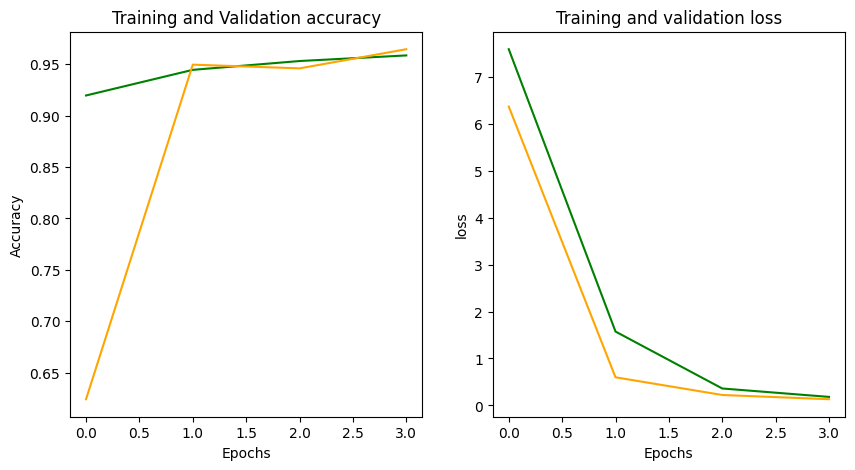

In [23]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='validation_accuracy', color='orange')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss', color = 'green')
plt.plot(history.history['val_loss'], label='validation_loss', color = 'orange')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.show()

### Model Evaluation

We evaluate the trained CNN model on both the training and validation datasets.

Training Accuracy: 97.17%

Training Loss: 0.1123

Validation Accuracy: 96.57%

Validation Loss: 0.1329

Insights:

The model performs very well on both training and validation sets.

Validation accuracy is close to training accuracy, indicating good generalization with minimal overfitting.

The low loss values further confirm the model has learned discriminative features effectively.

In [41]:
# model evaluation
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(validation_generator)


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 456s 243ms/step - accuracy: 0.9717 - loss: 0.1123
469/469 ━━━━━━━━━━━━━━━━━━━━ 115s 246ms/step - accuracy: 0.9657 - loss: 0.1329


### Confusion Matrix

We generate a confusion matrix to evaluate the model’s classification performance for each rice variety.

True Label (Y-axis): The actual class of the rice grain.

Predicted Label (X-axis): The class predicted by the model.

Diagonal cells: Correctly classified samples.

Off-diagonal cells: Misclassifications.

469/469 ━━━━━━━━━━━━━━━━━━━━ 129s 273ms/step


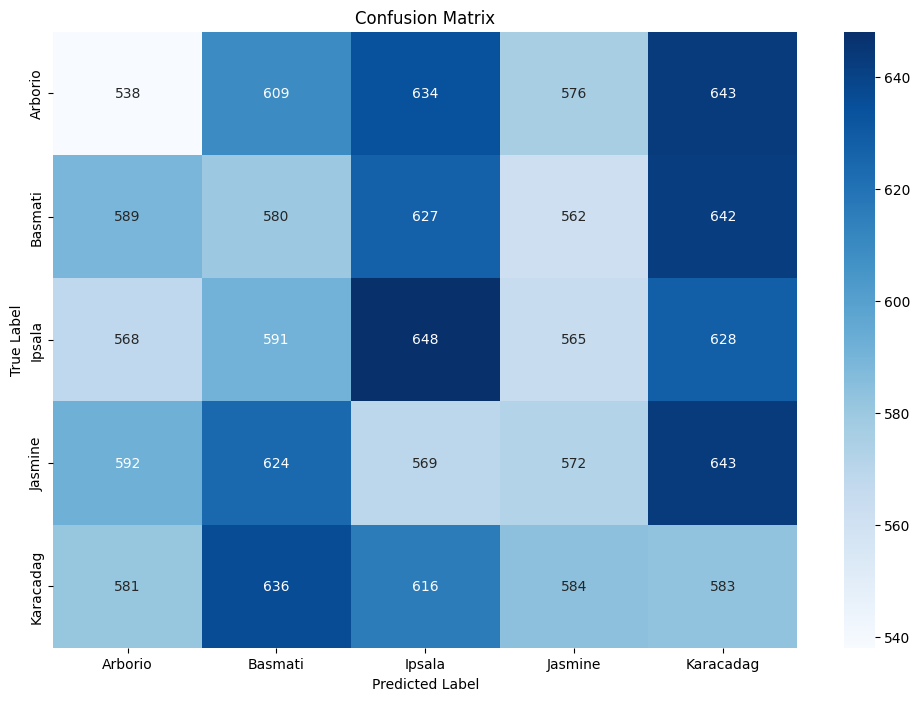

In [25]:
# plotting confusion matrix
true_classes = validation_generator.classes
predicted_classes = np.argmax(
    model.predict(
        validation_generator,
        steps=int(np.ceil(validation_generator.samples / validation_generator.batch_size))
    ),
    axis=1
)
class_labels = list(validation_generator.class_indices.keys())

# generate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# plotting with seaborn
plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


### Testing on a Single Image

We select one rice grain image from the dataset for individual prediction.

The img_path points to the image we want to test.

You can switch between different rice classes (e.g., Basmati, Ipsala, Arborio) by changing the path.

Next, we’ll load this image, preprocess it, and use the trained CNN model to predict its class.

In [34]:
# img_path = '/content/dataset/Rice_Image_Dataset/Basmati/Basmati (1).jpg'
img_path = '/content/dataset/Rice_Image_Dataset/Ipsala/Ipsala (1).jpg'

### Loading and Preprocessing the Test Image

We load the selected rice grain image and resize it to the same dimensions used for training (250×250 pixels).

image.load_img → Loads the image from the given path.

target_size=(250,250) → Resizes the image to the input size expected by the CNN.

color_mode='grayscale' → Ensures the image has a single channel, consistent with training.

The loaded image is ready to be converted into an array and normalized before prediction.                                                                                              

In [36]:
from tensorflow.keras.preprocessing import image
img = image.load_img(img_path, target_size=(250, 250), color_mode='grayscale')  # or 'rgb' if using 3 channels

### Converting Image to Array for Prediction

We convert the preprocessed image into a NumPy array and normalize it for model prediction.

image.img_to_array(img) → Converts the PIL image into a NumPy array.

np.expand_dims(img_array, axis=0) → Adds an extra dimension to represent the batch size (since the model expects batches).

img_array / 255.0 → Normalizes pixel values to the [0,1] range (just like training images).

In [38]:
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

### Making Prediction on the Test Image

We pass the processed image through the trained CNN model to predict its rice variety.

model.predict(img_array) → Generates probability scores for each class.

np.argmax(pred) → Finds the index of the class with the highest probability.

class_labels → Maps the index to the actual rice class name.

np.max(pred) → Shows the confidence score for the predicted class.

In [40]:
# Predict
pred = model.predict(img_array)
predicted_class_index = np.argmax(pred)

# Get class label
class_labels = list(train_generator.class_indices.keys())
predicted_class = class_labels[predicted_class_index]

print(f"Predicted Class: {predicted_class} (Confidence: {np.max(pred):.2f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Predicted Class: Ipsala (Confidence: 1.00)


###  Conclusion

The CNN model achieved high accuracy in classifying rice grains across five varieties — Arborio, Basmati, Ipsala, Jasmine, and Karacadag.  
The evaluation metrics and confusion matrix confirm the model’s strong performance, with minimal misclassifications.  
Testing on individual images further validated its reliability, with predictions showing very high confidence scores.  
This project demonstrates the potential of deep learning in agricultural applications, helping in automating quality control and classification tasks effectively.